In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install -Uqq pandas investpy python-dateutil networkx matplotlib scikit-learn great-expectations seaborn

In [4]:
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import investpy
from pathlib import Path
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass, field
from datetime import date
from typing import List

In [5]:
%matplotlib inline
pd.set_option('display.max_rows', 500)

In [6]:
# Global variables and constants
COUNTRY = "malaysia"                   # use investpy.get_stock_countries() to list supported countries
DATASET_FOLDER = "test_data"
TARGET_DATASET_FOLDER = f"{DATASET_FOLDER}/{COUNTRY}"
STOCKS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks.csv"
STOCKS_INFO_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_info.csv"
STOCKS_FINANCE_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_finance.csv"
STOCKS_DIVIDENDS_DATASET = f"{TARGET_DATASET_FOLDER}/stocks_dividends.csv"
STOCKS_SELECTED = f"{TARGET_DATASET_FOLDER}/stocks_selected.csv"

In [7]:
def create_folder(folder):
    """Create folder if not exists"""
    if not os.path.exists(folder):
        os.makedirs(folder)

@dataclass
class DividendYield:
    year:int = 0
    percentage: float = 0.0
    
@dataclass
class Stock:
    country: str = ''
    name: str = ''
    symbol: str = ''
    pe_ratio: float = 0.0
    yields: List[int] = field(default_factory=list)

# Create target folder
create_folder(TARGET_DATASET_FOLDER)

In [8]:
# Get stocks for the country
df_stocks = investpy.get_stocks(country=COUNTRY)
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    929 non-null    object
 1   name       929 non-null    object
 2   full_name  929 non-null    object
 3   isin       929 non-null    object
 4   currency   929 non-null    object
 5   symbol     929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [9]:
display(df_stocks.head(10))

,country,name,full_name,isin,currency,symbol
0,malaysia,Media Chinese Int,Media Chinese International Ltd,BMG5959D1048,MYR,MDCH
1,malaysia,AMMB,AMMB Holdings Bhd,MYL1015OO006,MYR,AMMB
2,malaysia,CIMB Group,CIMB Group Holdings Bhd,MYL1023OO000,MYR,CIMB
3,malaysia,RHB Bank,RHB Bank Bhd,MYL1066OO009,MYR,RHBC
4,malaysia,Hong Leong Financial,Hong Leong Financial Group Bhd,MYL1082OO006,MYR,HLCB
5,malaysia,Malayan Banking,Malayan Banking Bhd,MYL1155OO000,MYR,MBBM
6,malaysia,Malaysia Building,Malaysia Building Society Bhd,MYL1171OO007,MYR,MBSS
7,malaysia,Public Bank,Public Bank Bhd,MYL1295OO004,MYR,PUBM
8,malaysia,Berjaya Sports Toto,Berjaya Sports Toto Bhd,MYL1562OO007,MYR,BSTB
9,malaysia,DRB Hicom,DRB - Hicom Bhd,MYL1619OO005,MYR,DRBM


In [10]:
def save_csv(df, file_name):
    df.to_csv(file_name, header=True, index=False)

# Save stock list
save_csv(df_stocks, STOCKS_DATASET)

In [11]:
def get_stock_info(symbol, country):
    try:
        return investpy.get_stock_information(symbol, country)
    except:
        return None
    
def get_stock_dividends(symbol, country):
    try:
        return investpy.get_stock_dividends(symbol, country)
    except:
        return None
    
def read_csv(file):
    if not os.path.isfile(file):
        return None
    return pd.read_csv(file)

def download_stocks_info(df):
    df_stocks_info = None
    count = 0
    for _, row in df.iterrows():
        count = count + 1
        print(f"{count}/{len(df)}: {row.symbol}-{row['name']}")
        df_stock = get_stock_info(row.symbol, row.country)
        if df_stock is None:
            continue
        if df_stocks_info is None:
            df_stocks_info  = df_stock
        else:
            df_stocks_info = df_stocks_info.append(df_stock)
        if count % 10 == 0:
            save_csv(df_stocks_info, STOCKS_INFO_DATASET)
            time.sleep(3)
    save_csv(df_stocks_info, STOCKS_INFO_DATASET)

def download_stocks_dividends(df):
    df_stocks_dividends = None
    count = 0
    for _, row in df.iterrows():
            count = count + 1
            print(f"{count}/{len(df)}: {row.symbol}-{row['name']}")
            df_stock = get_stock_dividends(row.symbol, row.country)
            if df_stock is None:
                continue
            df_stock['Symbol'] = row.symbol
            if df_stocks_dividends is None:
                df_stocks_dividends  = df_stock
            else:
                df_stocks_dividends = df_stocks_dividends.append(df_stock)
            if count % 10 == 0:
                save_csv(df_stocks_dividends, STOCKS_DIVIDENDS_DATASET)
                time.sleep(3)
    save_csv(df_stocks_dividends, STOCKS_DIVIDENDS_DATASET)

In [12]:
#download_stocks_info(df_stocks)

#download_stocks_dividends(df_stocks)

In [13]:
df_stocks_info = read_csv(STOCKS_INFO_DATASET)
display(df_stocks_info.head(10))

# Convert PE ratio
df_stocks_info['PE'] = df_stocks_info['P/E Ratio'].apply(lambda x: float(x.replace('%','').replace('-','0')))
#df_stocks_info['Next Earning'] = pd.to_datetime(df_stocks_info['Next Earnings Date'], format='%d/%m/%Y', errors='ignore')
display(df_stocks_info.head(10))
df_stocks_info.info()

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date
0,MDCH,0.19,0.19-0.195,490.27M,0.19,0.14-0.235,-,498000.0,311.1M,0.00(2.16%),5485763.0,-,-,26.67%,1.687236e+09,01/09/2021
1,AMMB,2.90,2.9-3.02,3900000000.0,2.91,2.63-3.79,-1.27,9332600.0,9610000000.0,N/A(N/A),3181045.0,-,1.1,-2.68%,3.314011e+09,26/08/2021
2,CIMB,4.68,4.68-4.83,16420000000.000002,4.68,2.9-4.83,0.32,26748800.0,46870000000.0,0.05(1.03%),11481116.0,14.77,1.95,36.44%,1.001418e+10,30/08/2021
3,RHBC,5.34,5.35-5.43,5380000000.0,5.36,4.17-5.98,0.52,6028500.0,21730000000.0,0.18(3.37%),2387024.0,10.31,1.01,11.25%,4.068360e+09,01/09/2021
4,HLCB,17.32,17.3-18.02,4680000000.0,17.48,12.34-18.7,1.96,289700.0,19640000000.0,0.36(2.07%),166766.0,8.86,1.04,37.68%,1.133789e+09,01/09/2021
5,MBBM,8.17,8.16-8.32,22890000000.0,8.17,6.96-9.01,0.6,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021
6,MBSS,0.61,0.61-0.635,1640000000.0,0.61,0.485-0.77,0.06,18132000.0,4370000000.0,0.02(3.33%),6570521.0,10.23,1.16,11.93%,7.171484e+09,02/09/2021
7,PUBM,3.94,3.93-4.13,9480000000.0,3.94,2.97-4.97,0.26,56126400.0,76480000000.0,0.03(3.30%),17805673.0,15.08,0.86,13.87%,1.941069e+10,24/08/2021
8,BSTB,2.00,1.99-2.04,4830000000.0,2.00,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021
9,DRBM,1.59,1.6-1.65,14550000000.0,1.60,1.58-2.25,0.41,2419300.0,3070000000.0,0.02(1.24%),1283879.0,3.85,2.26,-22.82%,1.933237e+09,26/08/2021


,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE
0,MDCH,0.19,0.19-0.195,490.27M,0.19,0.14-0.235,-,498000.0,311.1M,0.00(2.16%),5485763.0,-,-,26.67%,1.687236e+09,01/09/2021,0.00
1,AMMB,2.90,2.9-3.02,3900000000.0,2.91,2.63-3.79,-1.27,9332600.0,9610000000.0,N/A(N/A),3181045.0,-,1.1,-2.68%,3.314011e+09,26/08/2021,0.00
2,CIMB,4.68,4.68-4.83,16420000000.000002,4.68,2.9-4.83,0.32,26748800.0,46870000000.0,0.05(1.03%),11481116.0,14.77,1.95,36.44%,1.001418e+10,30/08/2021,14.77
3,RHBC,5.34,5.35-5.43,5380000000.0,5.36,4.17-5.98,0.52,6028500.0,21730000000.0,0.18(3.37%),2387024.0,10.31,1.01,11.25%,4.068360e+09,01/09/2021,10.31
4,HLCB,17.32,17.3-18.02,4680000000.0,17.48,12.34-18.7,1.96,289700.0,19640000000.0,0.36(2.07%),166766.0,8.86,1.04,37.68%,1.133789e+09,01/09/2021,8.86
5,MBBM,8.17,8.16-8.32,22890000000.0,8.17,6.96-9.01,0.6,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021,13.53
6,MBSS,0.61,0.61-0.635,1640000000.0,0.61,0.485-0.77,0.06,18132000.0,4370000000.0,0.02(3.33%),6570521.0,10.23,1.16,11.93%,7.171484e+09,02/09/2021,10.23
7,PUBM,3.94,3.93-4.13,9480000000.0,3.94,2.97-4.97,0.26,56126400.0,76480000000.0,0.03(3.30%),17805673.0,15.08,0.86,13.87%,1.941069e+10,24/08/2021,15.08
8,BSTB,2.00,1.99-2.04,4830000000.0,2.00,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021,14.73
9,DRBM,1.59,1.6-1.65,14550000000.0,1.60,1.58-2.25,0.41,2419300.0,3070000000.0,0.02(1.24%),1283879.0,3.85,2.26,-22.82%,1.933237e+09,26/08/2021,3.85


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Stock Symbol        923 non-null    object 
 1   Prev. Close         923 non-null    float64
 2   Todays Range        923 non-null    object 
 3   Revenue             923 non-null    object 
 4   Open                923 non-null    float64
 5   52 wk Range         923 non-null    object 
 6   EPS                 923 non-null    object 
 7   Volume              923 non-null    float64
 8   Market Cap          923 non-null    object 
 9   Dividend (Yield)    923 non-null    object 
 10  Average Vol. (3m)   923 non-null    object 
 11  P/E Ratio           923 non-null    object 
 12  Beta                923 non-null    object 
 13  1-Year Change       923 non-null    object 
 14  Shares Outstanding  923 non-null    float64
 15  Next Earnings Date  923 non-null    object 
 16  PE      

In [14]:
df_stocks_dividends = read_csv(STOCKS_DIVIDENDS_DATASET)
display(df_stocks_dividends.head(10))
#display(df_stocks_dividends[df_stocks_dividends['Symbol'] == 'MBBM'].head(10))

df_stocks_dividends['Year'] = df_stocks_dividends['Date'].apply(lambda x: int(x[0:4]))
df_stocks_dividends['Yield'] = df_stocks_dividends['Yield'].apply(lambda x: float(x.replace('%','').replace('-','0')))
#display(df_stocks_dividends[df_stocks_dividends['Symbol'] == 'MBBM'].head(10))
df_stocks_dividends.info()

,Date,Dividend,Type,Payment Date,Yield,Symbol
0,2021-06-18,0.0041,trailing_twelve_months,2021-07-08,2.16%,MDCH
1,2020-07-10,0.0041,trailing_twelve_months,2020-07-30,2.28%,MDCH
2,2019-12-09,0.0109,trailing_twelve_months,2019-12-30,5.59%,MDCH
3,2019-06-19,0.0117,trailing_twelve_months,2019-07-12,7.31%,MDCH
4,2018-12-12,0.0151,trailing_twelve_months,2018-12-28,7.95%,MDCH
5,2018-06-18,0.0171,trailing_twelve_months,2018-07-13,8.55%,MDCH
6,2017-12-11,0.0250,trailing_twelve_months,2017-12-29,8.47%,MDCH
7,2017-06-16,0.0307,trailing_twelve_months,2017-07-10,7.31%,MDCH
8,2016-12-13,0.0428,trailing_twelve_months,2016-12-30,7.25%,MDCH
9,2016-06-20,0.0451,trailing_twelve_months,2016-07-13,6.35%,MDCH


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4674 entries, 0 to 4673
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          4674 non-null   object 
 1   Dividend      4674 non-null   float64
 2   Type          4674 non-null   object 
 3   Payment Date  4674 non-null   object 
 4   Yield         4674 non-null   float64
 5   Symbol        4674 non-null   object 
 6   Year          4674 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 255.7+ KB


In [15]:
# Average 2 years yield
df_dividends_summary = df_stocks_dividends[ (df_stocks_dividends['Year'] == 2021) | (df_stocks_dividends['Year'] == 2020) ][['Symbol','Yield']]

# display(df_dividends_summary[df_dividends_summary['Symbol']=='MBBM'].head(10))

df_dividends_summary = df_dividends_summary.groupby(['Symbol']).sum()
df_dividends_summary['Yield'] = df_dividends_summary['Yield'] / 2   # Average over 2 years
# df_dividends_summary = df_dividends_summary.groupby(['Symbol']).mean()

df_dividends_summary.reset_index(inplace=True)

#display(df_dividends_summary.head(20))

In [16]:
# https://ng.investing.com/equities/malayan-banking-bhd-ratios

df_summary = pd.merge(df_stocks_info, df_dividends_summary, how='left', left_on=['Stock Symbol'], right_on=['Symbol'])
display(df_summary.head(10))

# Choose columns
#df_summary = df_summary[['Symbol', 'PE', 'Yield']]
#display(df_summary.head(10))
def convert_uom(v): 
    if "M" in v:
        return float(v[0:len(v)-1]) * 1_000_000
    elif "K" in v:
        return float(v[0:len(v)-1]) * 1_000
    elif v == "-":
        return 0
    elif "%" in v:
        return float(v[0:len(v)-1].replace(",",""))
    else:
        return float(v)
  
df_summary['EPS'] = df_summary['EPS'].apply(convert_uom)

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
0,MDCH,0.19,0.19-0.195,490.27M,0.19,0.14-0.235,-,498000.0,311.1M,0.00(2.16%),5485763.0,-,-,26.67%,1.687236e+09,01/09/2021,0.00,MDCH,2.220
1,AMMB,2.90,2.9-3.02,3900000000.0,2.91,2.63-3.79,-1.27,9332600.0,9610000000.0,N/A(N/A),3181045.0,-,1.1,-2.68%,3.314011e+09,26/08/2021,0.00,AMMB,2.350
2,CIMB,4.68,4.68-4.83,16420000000.000002,4.68,2.9-4.83,0.32,26748800.0,46870000000.0,0.05(1.03%),11481116.0,14.77,1.95,36.44%,1.001418e+10,30/08/2021,14.77,CIMB,3.330
3,RHBC,5.34,5.35-5.43,5380000000.0,5.36,4.17-5.98,0.52,6028500.0,21730000000.0,0.18(3.37%),2387024.0,10.31,1.01,11.25%,4.068360e+09,01/09/2021,10.31,RHBC,6.350
4,HLCB,17.32,17.3-18.02,4680000000.0,17.48,12.34-18.7,1.96,289700.0,19640000000.0,0.36(2.07%),166766.0,8.86,1.04,37.68%,1.133789e+09,01/09/2021,8.86,HLCB,2.215
5,MBBM,8.17,8.16-8.32,22890000000.0,8.17,6.96-9.01,0.6,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021,13.53,MBBM,10.310
6,MBSS,0.61,0.61-0.635,1640000000.0,0.61,0.485-0.77,0.06,18132000.0,4370000000.0,0.02(3.33%),6570521.0,10.23,1.16,11.93%,7.171484e+09,02/09/2021,10.23,MBSS,4.065
7,PUBM,3.94,3.93-4.13,9480000000.0,3.94,2.97-4.97,0.26,56126400.0,76480000000.0,0.03(3.30%),17805673.0,15.08,0.86,13.87%,1.941069e+10,24/08/2021,15.08,PUBM,3.430
8,BSTB,2.00,1.99-2.04,4830000000.0,2.00,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021,14.73,BSTB,14.250
9,DRBM,1.59,1.6-1.65,14550000000.0,1.60,1.58-2.25,0.41,2419300.0,3070000000.0,0.02(1.24%),1283879.0,3.85,2.26,-22.82%,1.933237e+09,26/08/2021,3.85,DRBM,1.150


In [17]:
# Short list stocks
df_selected = df_summary[  (df_summary['PE'] < 15) & (df_summary['PE'] > 0) & (df_summary['Yield'] > 8)  ]

display(len(df_selected))
display(df_selected.head(100))

#df_temp = df_stocks_info[ df_stocks_info['Stock Symbol'].isin(df_selected['Symbol']) ]
#display(df_temp)

# TODO - earning date is < 30 days from now
# display( df_temp[ pd.to_datetime(df_temp['Next Earnings Date'], format='%d/%m/%Y', errors='coerce') > pd.Timestamp('today')] )

display(df_stocks[ df_stocks['symbol'].isin(df_selected['Symbol']) ])

# display(df_stocks_dividends[ (df_stocks_dividends['Symbol'].isin(df_selected['Symbol'])) &  ((df_stocks_dividends['Year'] == 2021) | (df_stocks_dividends['Year'] == 2020)) ])
# Save
save_csv(df_selected, STOCKS_SELECTED)

31

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
5,MBBM,8.170,8.16-8.32,22890000000.0,8.170,6.96-9.01,0.60,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021,13.53,MBBM,10.310
8,BSTB,2.000,1.99-2.04,4830000000.0,2.000,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021,14.73,BSTB,14.250
11,BMYS,7.330,7.35-7.53,878.24M,7.350,7.31-9.9,0.54,3397500.0,5930000000.0,0.50(6.61%),1280013.0,13.57,1.21,-26.26%,8.092991e+08,02/11/2021,13.57,BMYS,8.620
31,BATO,14.000,13.96-14.1,2450000000.0,13.980,9.8-16.2,0.95,178200.0,359310000000.0,0.93(6.60%),316373.0,14.74,0.49,35.92%,2.288578e+09,24/08/2021,14.74,BATO,31.240
42,UOAD,1.590,1.58-1.62,609.5M,1.600,1.46-1.92,0.15,1813800.0,3700000000.0,0.14(8.86%),558834.0,10.75,0.78,-4.22%,2.326466e+09,31/08/2021,10.75,UOAD,8.320
46,TPGC,3.760,3.74-3.85,17400000000.0,3.770,3.64-9.72,1.05,7641600.0,30110000000.0,0.59(15.72%),19801147.0,3.58,0.78,-59.7%,8.006863e+09,17/09/2021,3.58,TPGC,17.435
82,ASTR,1.090,1.08-1.11,4370000000.0,1.090,0.71-1.26,0.12,3623600.0,5680000000.0,0.09(7.87%),5383905.0,9.37,1.32,42.48%,5.214507e+09,16/09/2021,9.37,ASTR,21.245
88,KRIB,3.060,3.04-3.17,6760000000.0,3.070,2.93-8.39,1.17,3109300.0,7810000000.0,0.24(7.64%),5491692.0,2.61,1.42,-62.68%,2.551620e+09,08/11/2021,2.61,KRIB,8.055
155,BERA,1.580,1.57-1.63,2290000000.0,1.590,1.12-1.64,0.12,4542600.0,1840000000.0,0.05(3.17%),1953342.0,13.74,1.35,14.49%,1.161428e+09,16/09/2021,13.74,BERA,12.810
231,DOMN,0.815,0.825-0.87,601.04M,0.825,0.655-1.2,0.09,589800.0,134.67M,0.03(4.29%),84497.0,8.98,0.49,18.12%,1.652402e+08,30/08/2021,8.98,DOMN,10.835


,country,name,full_name,isin,currency,symbol
5,malaysia,Malayan Banking,Malayan Banking Bhd,MYL1155OO000,MYR,MBBM
8,malaysia,Berjaya Sports Toto,Berjaya Sports Toto Bhd,MYL1562OO007,MYR,BSTB
11,malaysia,Bursa Malaysia,Bursa Malaysia Bhd,MYL1818OO003,MYR,BMYS
31,malaysia,BAT Malaysia,British American Tobacco Malaysia Bhd,MYL4162OO003,MYR,BATO
42,malaysia,UOA Development,UOA Development Bhd,MYL5200OO000,MYR,UOAD
46,malaysia,Top Glove Corp,Top Glove Corporation Bhd,MYL7113OO003,MYR,TPGC
84,malaysia,Astro Malaysia,Astro Malaysia Holdings Bhd,MYL6399OO009,MYR,ASTR
90,malaysia,Kossan Rubber Ind,Kossan Rubber Industries Bhd,MYL7153OO009,MYR,KRIB
157,malaysia,Bermaz Auto,Bermaz Auto Bhd,MYL5248OO009,MYR,BERA
233,malaysia,Dominant Enterprise,Dominant Enterprise Bhd,MYL7169OO005,MYR,DOMN


## Stock Clustering

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [19]:
df_analysis = pd.merge(df_stocks_info, df_dividends_summary, how='left', left_on=['Stock Symbol'], right_on=['Symbol'])
df_analysis['Stock Symbol'] = df_analysis['Stock Symbol'].astype('category')
display(df_analysis.head(10))

# Stocks without any dividends
#df_analysis[df_analysis.isna().any(axis=1)].head(100)

# Drop columnss 
cols = ['Next Earnings Date', 'Todays Range', 'Prev. Close', 'Open', '52 wk Range', 'Dividend (Yield)', 'P/E Ratio', 'Symbol']
df_analysis.drop(columns=cols, inplace=True)
# display(df_analysis.head(10))

#display(df_analysis.head(10))
display(df_analysis.info())
#print(len(df_analysis))

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date,PE,Symbol,Yield
0,MDCH,0.19,0.19-0.195,490.27M,0.19,0.14-0.235,-,498000.0,311.1M,0.00(2.16%),5485763.0,-,-,26.67%,1.687236e+09,01/09/2021,0.00,MDCH,2.220
1,AMMB,2.90,2.9-3.02,3900000000.0,2.91,2.63-3.79,-1.27,9332600.0,9610000000.0,N/A(N/A),3181045.0,-,1.1,-2.68%,3.314011e+09,26/08/2021,0.00,AMMB,2.350
2,CIMB,4.68,4.68-4.83,16420000000.000002,4.68,2.9-4.83,0.32,26748800.0,46870000000.0,0.05(1.03%),11481116.0,14.77,1.95,36.44%,1.001418e+10,30/08/2021,14.77,CIMB,3.330
3,RHBC,5.34,5.35-5.43,5380000000.0,5.36,4.17-5.98,0.52,6028500.0,21730000000.0,0.18(3.37%),2387024.0,10.31,1.01,11.25%,4.068360e+09,01/09/2021,10.31,RHBC,6.350
4,HLCB,17.32,17.3-18.02,4680000000.0,17.48,12.34-18.7,1.96,289700.0,19640000000.0,0.36(2.07%),166766.0,8.86,1.04,37.68%,1.133789e+09,01/09/2021,8.86,HLCB,2.215
5,MBBM,8.17,8.16-8.32,22890000000.0,8.17,6.96-9.01,0.6,11938400.0,95530000000.0,0.52(6.50%),6173324.0,13.53,1.07,8.21%,1.169334e+10,26/08/2021,13.53,MBBM,10.310
6,MBSS,0.61,0.61-0.635,1640000000.0,0.61,0.485-0.77,0.06,18132000.0,4370000000.0,0.02(3.33%),6570521.0,10.23,1.16,11.93%,7.171484e+09,02/09/2021,10.23,MBSS,4.065
7,PUBM,3.94,3.93-4.13,9480000000.0,3.94,2.97-4.97,0.26,56126400.0,76480000000.0,0.03(3.30%),17805673.0,15.08,0.86,13.87%,1.941069e+10,24/08/2021,15.08,PUBM,3.430
8,BSTB,2.00,1.99-2.04,4830000000.0,2.00,1.88-2.27,0.14,811000.0,2680000000.0,0.12(6.16%),577756.0,14.73,0.08,-4.27%,1.341900e+09,16/11/2021,14.73,BSTB,14.250
9,DRBM,1.59,1.6-1.65,14550000000.0,1.60,1.58-2.25,0.41,2419300.0,3070000000.0,0.02(1.24%),1283879.0,3.85,2.26,-22.82%,1.933237e+09,26/08/2021,3.85,DRBM,1.150


<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 922
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Stock Symbol        923 non-null    category
 1   Revenue             923 non-null    object  
 2   EPS                 923 non-null    object  
 3   Volume              923 non-null    float64 
 4   Market Cap          923 non-null    object  
 5   Average Vol. (3m)   923 non-null    object  
 6   Beta                923 non-null    object  
 7   1-Year Change       923 non-null    object  
 8   Shares Outstanding  923 non-null    float64 
 9   PE                  923 non-null    float64 
 10  Yield               429 non-null    float64 
dtypes: category(1), float64(4), object(6)
memory usage: 120.6+ KB


None

In [34]:
cat_feats = ['Stock Symbol']
#num_feats = list(df_analysis)
#num_feats.remove("Stock Symbol")
num_feats = ['PE', 'Yield'] # Use only features we considered important
df_analysis.dropna(subset = ["Yield"], inplace=True) # Remove stocks with 0 yield


print("Categorical features: ", cat_feats)
print("Numerical features: ", num_feats)

class DataCleanser(BaseEstimator, TransformerMixin):
    
    def __init__(self, attrib_names):
        self.attrib_names = attrib_names
    
    def _convert_uom(self, v): 
        if "M" in v:
            return float(v[0:len(v)-1]) * 1_000_000
        elif "K" in v:
            return float(v[0:len(v)-1]) * 1_000
        elif v == "-":
            return 0
        elif "%" in v:
            return float(v[0:len(v)-1].replace(",",""))
        else:
            return float(v)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for attr in self.attrib_names:
            if X.dtypes[attr] == object:
                X[attr] = X[attr].apply(self._convert_uom)
        return X
    
num_pipeline = Pipeline([
         ('cleanser', DataCleanser(num_feats)),
         ('imputer', SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0)),
         ('std_scaler', StandardScaler()) 
])

cat_pipeline = Pipeline([
         ('cat_encoder', OrdinalEncoder()) 
])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_feats),
        ("cat", cat_pipeline, cat_feats),
])

df_prepared = full_pipeline.fit_transform(df_analysis)
display(df_prepared)

Categorical features:  ['Stock Symbol']
Numerical features:  ['PE', 'Yield']


array([[-3.21782033e-01, -4.32603552e-01,  2.30000000e+02],
       [-3.21782033e-01, -4.04929112e-01,  1.20000000e+01],
       [-1.42541454e-01, -1.96306410e-01,  5.40000000e+01],
       ...,
       [-1.22396609e-01, -2.20787646e-01,  1.49000000e+02],
       [ 1.45554101e-01, -8.57299767e-01,  2.33000000e+02],
       [-1.61958172e-01,  4.48720924e-01,  2.52000000e+02]])

KMeans(n_clusters=2)

1645715.162452507


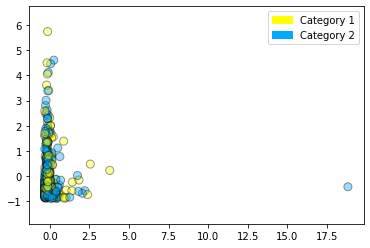

KMeans(n_clusters=3)

731943.2636551976


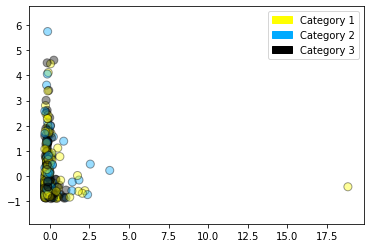

KMeans(n_clusters=4)

412162.89143661404


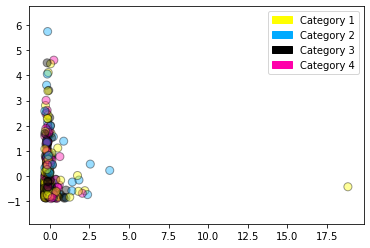

KMeans(n_clusters=5)

264055.21214210184


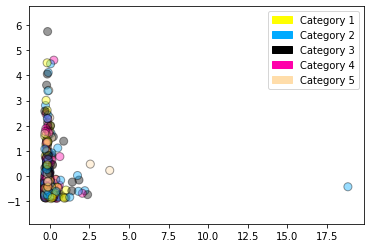

Text(0.5, 1.0, 'Elbow curve')

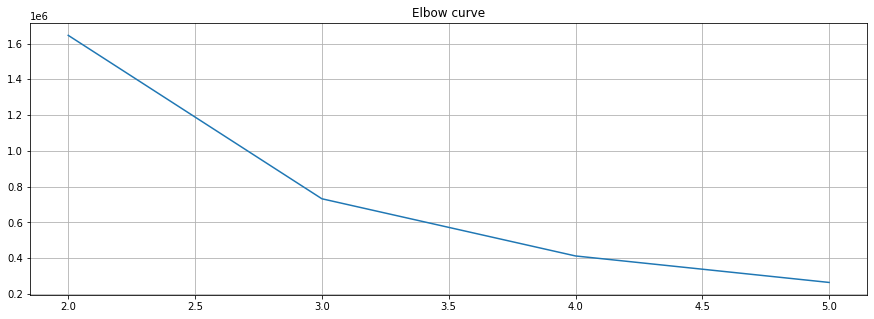

In [35]:
from sklearn.cluster import KMeans
from utils.visual import plot_labelled_scatter
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
for k in range(2,6):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_prepared)
    print(kmeans.inertia_)
    distortions.append(kmeans.inertia_)
    plot_labelled_scatter(df_prepared, kmeans.labels_, 
                          [ "Category " + str(i) for i in list(range(1,k+1)) ] )

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 6), distortions)
plt.grid(True)
plt.title('Elbow curve')

## Use Cluster = 3

KMeans(n_clusters=3)

731871.8712792529


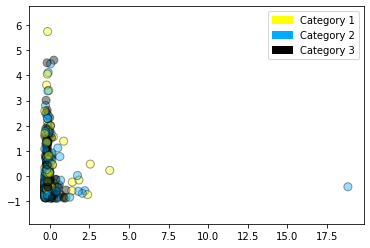

In [36]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_prepared)
print(kmeans.inertia_)
distortions.append(kmeans.inertia_)
plot_labelled_scatter(df_prepared, kmeans.labels_, 
                      [ "Category " + str(i) for i in list(range(1,4)) ] )

In [37]:
df_analysis['Category'] = kmeans.labels_
for i in range(0,3):
    display(len(df_analysis[df_analysis['Category'] == i]))
    display(df_analysis[df_analysis['Category'] == i])

143

,Stock Symbol,Revenue,EPS,Volume,Market Cap,Average Vol. (3m),Beta,1-Year Change,Shares Outstanding,PE,Yield,Category
1,AMMB,3900000000.0,-1.27,9332600.0,9610000000.0,3181045.0,1.1,-2.68%,3.314011e+09,0.00,2.350,0
2,CIMB,16420000000.000002,0.32,26748800.0,46870000000.0,11481116.0,1.95,36.44%,1.001418e+10,14.77,3.330,0
8,BSTB,4830000000.0,0.14,811000.0,2680000000.0,577756.0,0.08,-4.27%,1.341900e+09,14.73,14.250,0
9,DRBM,14550000000.0,0.41,2419300.0,3070000000.0,1283879.0,2.26,-22.82%,1.933237e+09,3.85,1.150,0
11,BMYS,878.24M,0.54,3397500.0,5930000000.0,1280013.0,1.21,-26.26%,8.092991e+08,13.57,8.620,0
15,GENP,2470000000.0,0.25,746800.0,6320000000.0,907234.0,0.36,-28.89%,8.971982e+08,27.85,2.265,0
17,ALLI,1560000000.0,0.23,1140100.0,3750000000.0,553944.0,1.25,14.15%,1.548106e+09,10.44,1.230,0
19,CBMS,1790000000.0,0.6,99800.0,6730000000.0,113624.0,1.07,-4.43%,3.057480e+08,36.92,8.225,0
20,DBMS,1110000000.0,1.06,24100.0,2049999999.9999998,5573.0,0.24,-17.48%,6.400000e+07,30.42,2.700,0
21,HAPS,5650000000.0,0.29,194400.0,19470000000.0,335781.0,0.8,-4.28%,2.489670e+09,27.40,5.000,0


143

,Stock Symbol,Revenue,EPS,Volume,Market Cap,Average Vol. (3m),Beta,1-Year Change,Shares Outstanding,PE,Yield,Category
3,RHBC,5380000000.0,0.52,6028500.0,21730000000.0,2387024.0,1.01,11.25%,4.068360e+09,10.31,6.350,1
7,PUBM,9480000000.0,0.26,56126400.0,76480000000.0,17805673.0,0.86,13.87%,1.941069e+10,15.08,3.430,1
13,TDMS,545.65M,0.0,1565500.0,430.72M,2988676.0,2.87,6.38%,1.722881e+09,208.33,1.540,1
32,SIME,41960000000.0,0.2,13511100.0,14690000000.0,4825371.0,1.09,0.47%,6.802537e+09,10.56,6.275,1
34,UMWS,10390000000.0,0.22,1686900.0,3560000000.0,432829.0,1.93,19.61%,1.168294e+09,13.84,1.015,1
36,TLMM,11090000000.0,0.31,3075700.0,22390000000.0,3323226.0,1.23,58.97%,3.827501e+09,18.71,3.470,1
37,TCOM,1260000000.0,0.18,2706800.0,8500000000.0,1649250.0,0.13,29.28%,1.821029e+09,26.35,0.805,1
39,ZHCO,165.73M,0.1,28600.0,846.4M,89719.0,1.02,27.78%,4.600000e+08,17.75,23.585,1
42,UOAD,609.5M,0.15,1813800.0,3700000000.0,558834.0,0.78,-4.22%,2.326466e+09,10.75,8.320,1
43,TENA,43800000000.0,0.67,1994800.0,56520000000.0,2819769.0,0.55,-10.27%,5.726091e+09,14.77,6.245,1


143

,Stock Symbol,Revenue,EPS,Volume,Market Cap,Average Vol. (3m),Beta,1-Year Change,Shares Outstanding,PE,Yield,Category
0,MDCH,490.27M,-,498000.0,311.1M,5485763.0,-,26.67%,1.687236e+09,0.00,2.220,2
4,HLCB,4680000000.0,1.96,289700.0,19640000000.0,166766.0,1.04,37.68%,1.133789e+09,8.86,2.215,2
5,MBBM,22890000000.0,0.6,11938400.0,95530000000.0,6173324.0,1.07,8.21%,1.169334e+10,13.53,10.310,2
6,MBSS,1640000000.0,0.06,18132000.0,4370000000.0,6570521.0,1.16,11.93%,7.171484e+09,10.23,4.065,2
10,MYRS,1000000000.0,-0.04,11435500.0,1720000000.0,6135994.0,2.83,-26.67%,4.467510e+09,0.00,2.370,2
12,IOIB,9830000000.0,0.2,2090200.0,23370000000.0,2256755.0,0.6,-15.73%,6.232878e+09,18.46,3.050,2
14,MMCB,4550000000.0,0.15,2278200.0,5510000000.0,10311353.0,1.35,168.15%,3.045059e+09,12.47,4.280,2
16,KLKK,17980000000.0,1.71,824000.0,21640000000.0,493095.0,0.69,-11.39%,1.077887e+09,11.77,4.765,2
23,IJMS,5620000000.0,0.12,3549100.0,6540000000.0,4365213.0,1.66,35.82%,3.591485e+09,15.31,3.490,2
27,MISC,9600000000.0,0.4,891600.0,30260000000.0,1401090.0,0.86,-13.08%,4.463746e+09,16.98,13.120,2


In [24]:
#code_pipeline = Pipeline([
#       ('selector', DataFrameSelector(code_attrib)),
#       ('code_encoder', OneHotEncoder(sparse=False))
#    ])

#full_pipeline = FeatureUnion(transformer_list=[
#        ("standard_attribs", standard_pipeline),
        #("code_attrib", code_pipeline)
#    ])

# df_prepared = full_pipeli